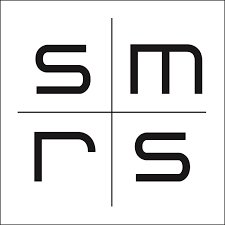

# Example map code

Libraries:
* Geopandas
* Plotly
* Folium

Techniques:
* Geocoding
* Create geodataframe from latitudes and longitudes
* CRS checking and changing
* reading geojson or shapefiles
* Creating Isochrones
* measuring distance

Map styles:
* points
* polygons
* choropleth
* heatmap
* interactivity

In [38]:
import pandas as pd
import matplotlib.pyplot as mpl

import geopandas as gpd
import contextily as ctx

import libpysal as lps
import plotly.express as px

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# geo imports
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point
from geopandas.tools import overlay



In [439]:
# display settings for notebook
%matplotlib inline
pd.set_option('display.max_columns',None)
pd.options.display.max_rows = 999

# Geocoding (Nominatim API)

There are usage limits that need to be respected.
Check the [documentation](https://nominatim.org/) for more info.

In [440]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="geoapiExercises")

def get_coordinates(place_name):
    location = geolocator.geocode(place_name)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Sample data
df1 = pd.DataFrame({'location': ['Reading', 'BD8 0AZ']})
df2 = pd.DataFrame({'location': ['Bangalore', 'Mumbai']})

df1['latitude'], df1['longitude'] = zip(*df1['location'].apply(get_coordinates))
df2['latitude'], df2['longitude'] = zip(*df2['location'].apply(get_coordinates))


In [442]:
df2

location   latitude  longitude
0  Bangalore  12.976794  77.590082
1     Mumbai  19.081577  72.886628

# Create geodataframe

A geodataframe is like a pandas dataframe with a special *geometry* column. The geometry column can contain points, polygons or multipolygons (multiple polygons e.g., to describe an town in two parts with a river splitting the shape into two polygons).

If you have longitude and latitude these can be combined to form a 'Point' data type.

In geopandas the active geometry column is automatically used to perform geo operations and plotting.

In [443]:
# convert pandas dataframe to geodataframe
gdf1 = gpd.GeoDataFrame(df1)

print(type(gdf1))


# create a special 'geometry' column containing points from latitudes and longitudes
# This will be your active geometry column
gdf1['geometry'] = gdf1.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Check the name of the active geometry column
print(gdf1.geometry.name)




#################################
# Another option is to transform the lat and long using a geopandas function
# gdf1 = gpd.GeoDataFrame(ldn_pcs, geometry=gpd.points_from_xy(df1['longitude'], df1['latitude']), crs = 'EPSG:27700')
#################################



<class 'geopandas.geodataframe.GeoDataFrame'>
geometry


/Users/rachelcooper/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


# Check and set CRS

The Coordinate Reference System (CRS) is used to provide context for the coordinates. It tells you where and how a point on a map corresponds to a location on the Earth.
Latitudes and longitudes are a **geometric CRS**. To plot our points on a flat surface we need a **projected CRS** 

In [448]:
# common CRS for UK maps:
gdf1.crs = "EPSG:27700"
# gdf1.to_crs = ('EPSG:27700')

gdf1.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

Depending on the extent of your map and the purpose you might need to use a different crs of which there are many to choose from.
Note: to change the crs you will need to **reproject** to the new crs. The crs won't change by calling something like the cell above.

Chosing the appropiate crs and checking that all your data is using the same one is a good way to debug problems with data appearing in the wrong location on the map.

In [43]:
reprojected_gdf = gdf1.to_crs("EPSG:4326")

reprojected_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Reading shapefiles

Shapefiles have a column with geometry. The shapefile has the extension .shp and this is the one we will read in. However, the other files which come with the .shp need to be kept in the same directory.

# Get the IMD shapefile
### Download it [here](https://www.arcgis.com/home/item.html?id=5e1c399d787e48c0902e5fe4fc1ccfe3)


In [449]:
# change this to your own
path = '/Users/rachelcooper/Downloads/IMD_2019 (1)/'

imd = gpd.read_file(path + 'IMD_2019.shp')
imd.head(3)

lsoa11cd             lsoa11nm            lsoa11nmw     st_areasha  \
0  E01000001  City of London 001A  City of London 001A  133320.768872   
1  E01000002  City of London 001B  City of London 001B  226191.272990   
2  E01000003  City of London 001C  City of London 001C   57302.966538   

    st_lengths  IMD_Rank  IMD_Decile             LSOA01NM      LADcd  \
0  2291.846072     29199           9  City of London 001A  E09000001   
1  2433.960112     30379          10  City of London 001B  E09000001   
2  1142.359799     14915           5  City of London 001C  E09000001   

            LADnm  IMDScore  IMDRank0  IMDDec0  IncScore  IncRank  IncDec  \
0  City of London     6.208     29199        9     0.007    32831      10   
1  City of London     5.143     30379       10     0.034    29901      10   
2  City of London    19.402     14915        5     0.086    18510       6   

   EmpScore  EmpRank  EmpDec  EduScore  EduRank  EduDec  HDDScore  HDDRank  \
0     0.010    32742      10     0.024    32842      10    -1.654    32113   
1     0.027    31190      10     0.063    32832      10    -1.115    29705   
2     0.086    15103       5     5.804    26386       9    -0.102    17600   

   HDDDec  CriScore  CriRank  CriDec  BHSScore  BHSRank  BHSDec  EnvScore  \
0      10    -2.012    32662      10    29.472     7319       3    31.873   
1      10    -2.343    32789      10    24.412    11707       4    23.084   
2       6    -1.032    29363       9    40.103     2157       1    40.535   

   EnvRank  EnvDec  IDCScore  IDCRank  IDCDec  IDOScore  IDORank  IDODec  \
0     7789       3     0.006    32806      10     0.012    32820      10   
1    13070       4     0.037    29682      10     0.030    31938      10   
2     4092       2     0.052    27063       9     0.128    16377       5   

   CYPScore  CYPRank  CYPDec  ASScore  ASRank  ASDec  GBScore  GBRank  GBDec  \
0    -2.107    32777      10    0.032   32843     10   -0.430   22985      7   
1    -1.907    32666      10    0.034   32841     10   -1.060   30223     10   
2    -0.292    20837       7    0.142   30999     10   -0.691   26719      9   

   WBScore  WBRank  WBDec  IndScore  IndRank  IndDec  OutScore  OutRank  \
0    3.587    3216      1     0.006    16364       5     1.503     1615   
1    3.231    3894      2    -0.410    22676       7     1.196     2969   
2    5.173     818      1    -0.054    17318       6     2.207      162   

   OutDec  TotPop  DepChi  Pop16_59  Pop60+  WorkPop  \
0       1    1296     175       656     465   715.00   
1       1    1156     182       580     394   619.75   
2       1    1350     146       759     445   804.00   

                                            geometry  
0  POLYGON ((532105.092 182011.230, 532162.491 18...  
1  POLYGON ((532746.813 181786.891, 532671.688 18...  
2  POLYGON ((532135.145 182198.119, 532158.250 18...

In [45]:
imd.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

# Plot a choropleth using Geopandas

### Download and import a basemap to plot onto

### [UK map shapefile including N Ireland, Scotland and Wales](https://borders.ukdataservice.ac.uk/easy_download_data.html?data=infuse_ctry_2011)

In [55]:
path = '/Users/rachelcooper/Library/CloudStorage/OneDrive-SMRS/Beds/'
UK_shape = gpd.read_file(path + 'infuse_ctry_2011/infuse_ctry_2011.shp') # crs = 'EPSG:27700'
UK_shape.crs


<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

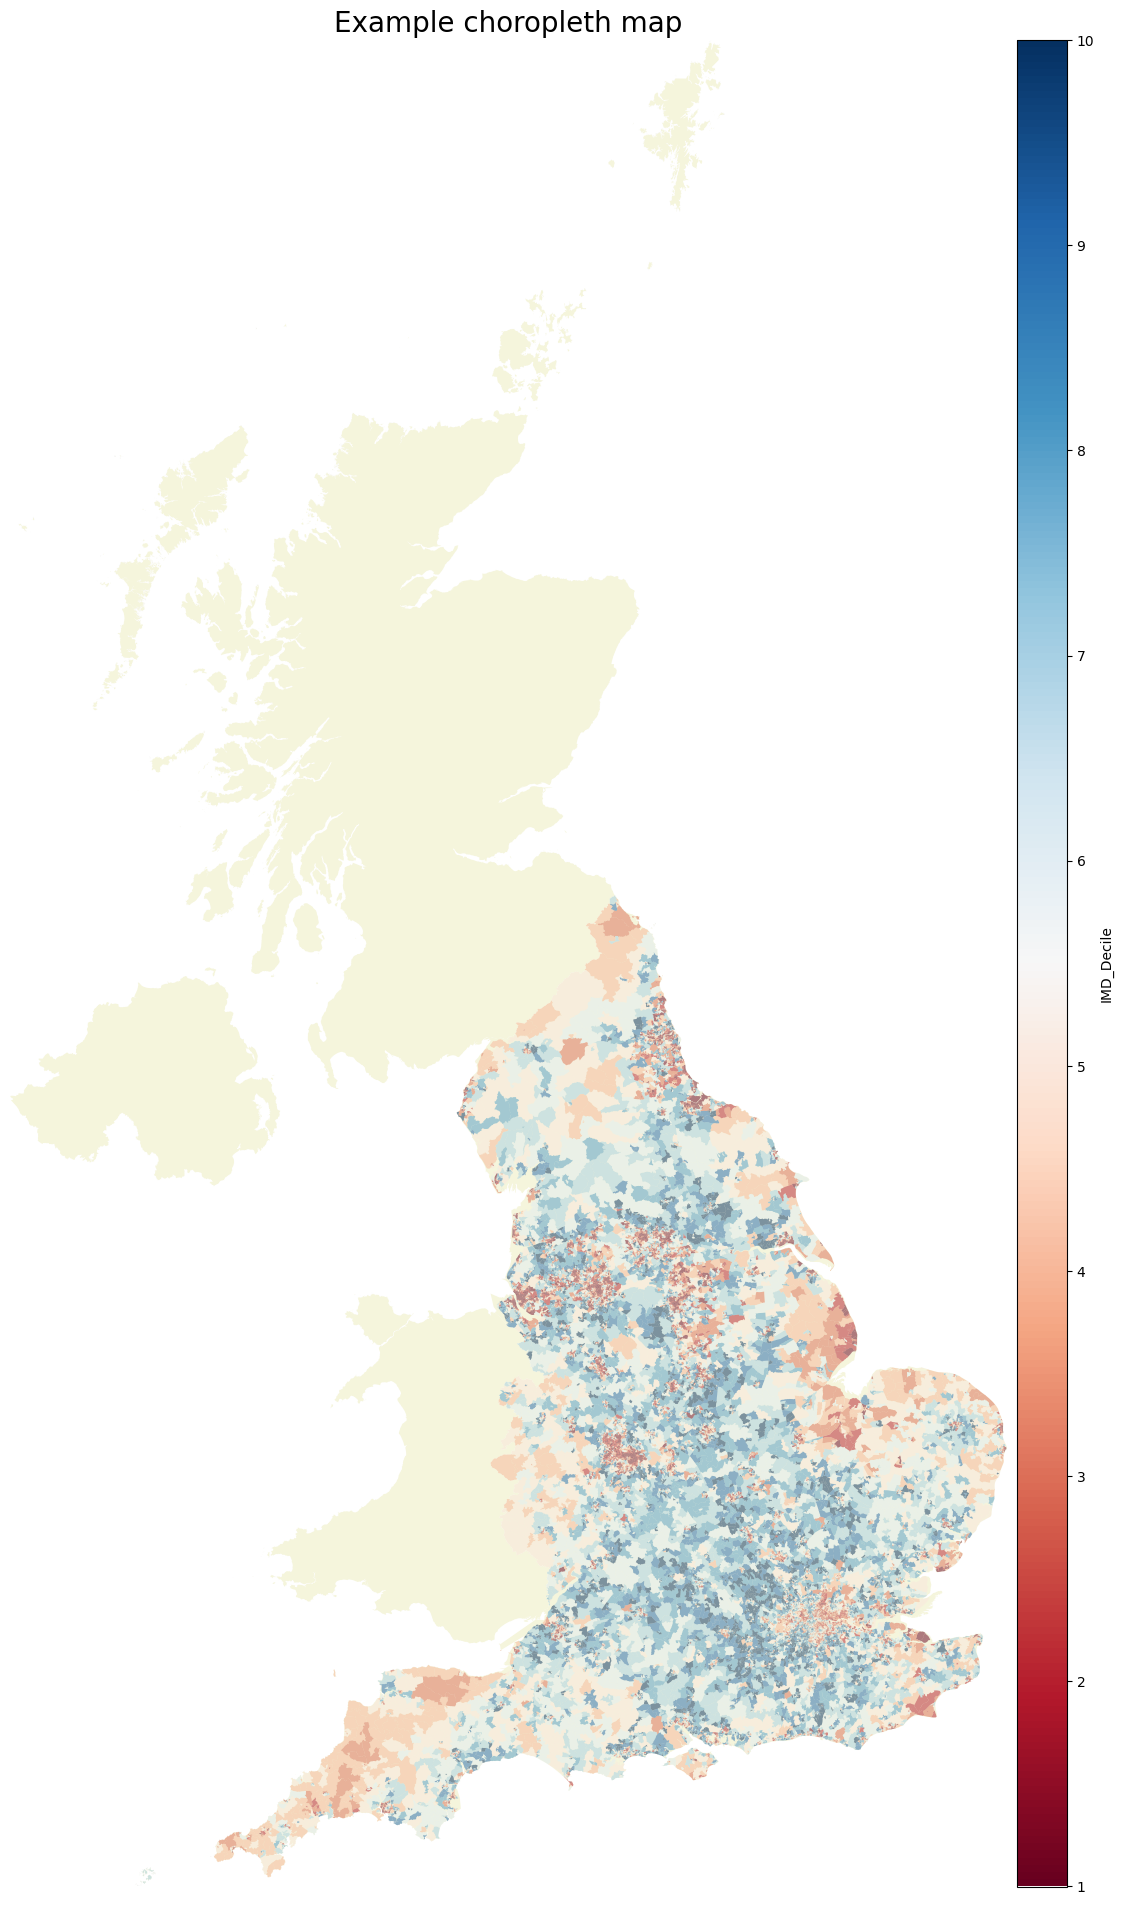

In [76]:
# plot

var = 'IMD_Decile'

fig = plt.figure(figsize = (30,30))
ax = fig.add_subplot(121)

divider = make_axes_locatable(ax)

base = UK_shape.plot(ax=ax, color = 'beige')
minx, miny, maxx, maxy = UK_shape.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
cax = divider.append_axes("right", size="5%", pad=0.1)


imd.plot(ax = base,
              column = var,
              cmap = 'RdBu',
              cax = cax,
              vmin=imd[var].min(), vmax=imd[var].max(),
              legend = True,
              legend_kwds={'label': var},
              alpha = .5)


ax.axis('off')
# Add title
ax.set_title('Example choropleth map', fontdict={'fontsize': 20}, loc='center')



plt.savefig(path + 'Example_Choropleth.png', dpi=300, bbox_inches='tight')


### The contextily library has some nicer looking basemaps to use.

In [58]:
# pip install contextily
import contextily as ctx

In [60]:
imd_reprojected = imd.to_crs(epsg=3857)
imd_reprojected.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

/Users/rachelcooper/opt/anaconda3/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


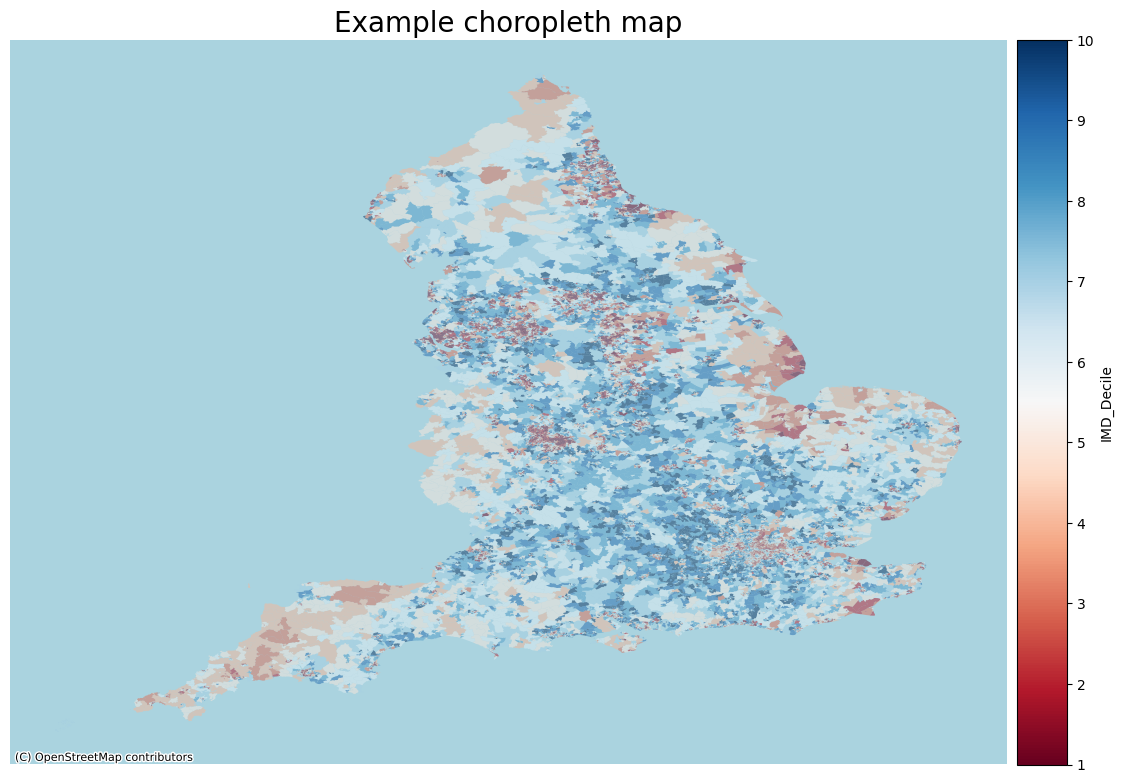

In [451]:
# plot

var = 'IMD_Decile'

fig = plt.figure(figsize = (30,30))
ax = fig.add_subplot(121)

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)

imd_reprojected.plot(ax = ax, # changed the ax to ax and not the uk basemap we used previously.
              column = var,
              cmap = 'RdBu',
              cax = cax,
              vmin=imd_reprojected[var].min(), vmax=imd_reprojected[var].max(),
              legend = True,
              legend_kwds={'label': var},
              alpha = .5)


ax.axis('off')
# Add title
ax.set_title('Example choropleth map', fontdict={'fontsize': 20}, loc='center')

# add the contextily basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
# There are a choices of contextily basemaps e.g.,
# source=ctx.providers.OpenStreetMap.Mapnik



plt.savefig(path + 'Example_Choropleth.png', dpi=300, bbox_inches='tight')


# Plot points

### Get some more points to play with

In [277]:
gdf_lnd_postcodes = gpd.read_file('/Users/rachelcooper/Library/CloudStorage/OneDrive-SMRS/London_60mins_postcodes.shp')
gdf_lnd_postcodes.head()

id postcode   latitude  longitude                   geometry
0  69025  WD7 9EU  51.694131  -0.292763  POINT (-0.29276 51.69413)
1  69026  WD7 9EW  51.684390  -0.272313  POINT (-0.27231 51.68439)
2  69027  WD7 9EX  51.693555  -0.292090  POINT (-0.29209 51.69356)
3  69028  WD7 9EY  51.694202  -0.291487  POINT (-0.29149 51.69420)
4  69029  WD7 9EZ  51.692161  -0.292099  POINT (-0.29210 51.69216)

In [278]:
gdf_lnd_postcodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

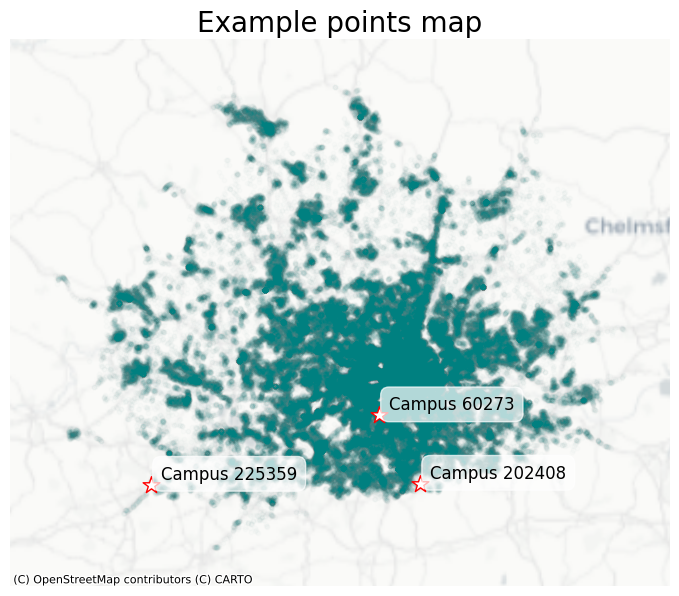

In [455]:
# plot points



fig = plt.figure(figsize = (30,30))
ax = fig.add_subplot(121)

divider = make_axes_locatable(ax)

minx, miny, maxx, maxy = gdf_lnd_postcodes.total_bounds

# add a buffer around the map extent to give room for labels
x_buffer = (maxx - minx) * 0.08
y_buffer = (maxy - miny) * 0.08

minx -= x_buffer
miny -= y_buffer
maxx += x_buffer
maxy += y_buffer

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)


gdf_lnd_postcodes.plot(
        ax = ax,
        color = 'teal',
        marker='o',
        markersize = 10,
        alpha = .01)

ax.axis('off')

# Add title
ax.set_title('Example points map', fontdict={'fontsize': 20}, loc='center')

# add the contextily basemap
ctx.add_basemap(ax, source = ctx.providers.CartoDB.Positron, crs=gdf_lnd_postcodes.crs, zoom=8)


# get a random subset to highlight
gdf_sampled = gdf_lnd_postcodes.sample(3)

# highlight some other points and annotate
from adjustText import adjust_text

offset = 0.02  # Adjust this value based on your map's extent and desired label positioning

texts = []
for i, point in gdf_sampled.iterrows():
    texts.append(plt.text(point.geometry.x + offset, point.geometry.y, f'Campus {i}', fontsize=12,
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5', alpha=0.7)))

adjust_text(texts)


gdf_sampled.plot(
        ax = ax,
        color = 'white',
        marker='*',
        markersize = 160,
        alpha = 1,
        edgecolor = 'red')

    
plt.savefig(path + 'Example_points_map.png', dpi=300, bbox_inches='tight')

# Spatial joins

# Perform a [spatial join](https://geopandas.org/en/stable/gallery/spatial_joins.html) to show which points are 'contained' in each local authority area in the IMD dataset. 

### There are other options for sjoins e.g., 'within' or 'intersects'. You can also add a buffer around each area before the join or find the nearest neighbour. See [here](https://shapely.readthedocs.io/en/latest/predicates.html)

In [292]:
imd_2 = imd.to_crs(gdf_lnd_postcodes.crs)
imd_2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [282]:
# Perform the spatial join
joined_gdf = gpd.sjoin(gdf_lnd_postcodes, imd_2, how="inner", predicate="within")

In [283]:
# Check a couple of points are contained in a polygon
print(any(imd_2.contains(gdf_lnd_postcodes.geometry.iloc[0])))
print(any(imd_2.contains(gdf_lnd_postcodes.geometry.iloc[1])))


True
True


In [284]:
joined_gdf.head()

id postcode   latitude  longitude                   geometry  \
0   69025  WD7 9EU  51.694131  -0.292763  POINT (-0.29276 51.69413)   
5   69030  WD7 9GA  51.699104  -0.288466  POINT (-0.28847 51.69910)   
14  69127  WD7 9HT  51.697273  -0.290561  POINT (-0.29056 51.69727)   
15  69128  WD7 9HU  51.697048  -0.289933  POINT (-0.28993 51.69705)   
17  69130  WD7 9HX  51.696844  -0.291330  POINT (-0.29133 51.69684)   

    index_right   lsoa11cd        lsoa11nm       lsoa11nmw    st_areasha  \
0         22954  E01023582  Hertsmere 004B  Hertsmere 004B  3.030249e+06   
5         22954  E01023582  Hertsmere 004B  Hertsmere 004B  3.030249e+06   
14        22954  E01023582  Hertsmere 004B  Hertsmere 004B  3.030249e+06   
15        22954  E01023582  Hertsmere 004B  Hertsmere 004B  3.030249e+06   
17        22954  E01023582  Hertsmere 004B  Hertsmere 004B  3.030249e+06   

      st_lengths  IMD_Rank  IMD_Decile        LSOA01NM      LADcd      LADnm  \
0   14037.057506     18178           6  Hertsmere 004B  E07000098  Hertsmere   
5   14037.057506     18178           6  Hertsmere 004B  E07000098  Hertsmere   
14  14037.057506     18178           6  Hertsmere 004B  E07000098  Hertsmere   
15  14037.057506     18178           6  Hertsmere 004B  E07000098  Hertsmere   
17  14037.057506     18178           6  Hertsmere 004B  E07000098  Hertsmere   

    IMDScore  IMDRank0  IMDDec0  IncScore  IncRank  IncDec  EmpScore  EmpRank  \
0     15.768     18178        6     0.094    17331       6     0.072    18348   
5     15.768     18178        6     0.094    17331       6     0.072    18348   
14    15.768     18178        6     0.094    17331       6     0.072    18348   
15    15.768     18178        6     0.094    17331       6     0.072    18348   
17    15.768     18178        6     0.094    17331       6     0.072    18348   

    EmpDec  EduScore  EduRank  EduDec  HDDScore  HDDRank  HDDDec  CriScore  \
0        6    12.316    19648       6    -0.362    21610       7     0.128   
5        6    12.316    19648       6    -0.362    21610       7     0.128   
14       6    12.316    19648       6    -0.362    21610       7     0.128   
15       6    12.316    19648       6    -0.362    21610       7     0.128   
17       6    12.316    19648       6    -0.362    21610       7     0.128   

    CriRank  CriDec  BHSScore  BHSRank  BHSDec  EnvScore  EnvRank  EnvDec  \
0     14685       5    35.192     3993       2    10.538    23498       8   
5     14685       5    35.192     3993       2    10.538    23498       8   
14    14685       5    35.192     3993       2    10.538    23498       8   
15    14685       5    35.192     3993       2    10.538    23498       8   
17    14685       5    35.192     3993       2    10.538    23498       8   

    IDCScore  IDCRank  IDCDec  IDOScore  IDORank  IDODec  CYPScore  CYPRank  \
0      0.129    16099       5     0.096    20606       7    -0.131    18269   
5      0.129    16099       5     0.096    20606       7    -0.131    18269   
14     0.129    16099       5     0.096    20606       7    -0.131    18269   
15     0.129    16099       5     0.096    20606       7    -0.131    18269   
17     0.129    16099       5     0.096    20606       7    -0.131    18269   

    CYPDec  ASScore  ASRank  ASDec  GBScore  GBRank  GBDec  WBScore  WBRank  \
0        6    0.266   19861      7    0.912    4024      2    0.836   11226   
5        6    0.266   19861      7    0.912    4024      2    0.836   11226   
14       6    0.266   19861      7    0.912    4024      2    0.836   11226   
15       6    0.266   19861      7    0.912    4024      2    0.836   11226   
17       6    0.266   19861      7    0.912    4024      2    0.836   11226   

    WBDec  IndScore  IndRank  IndDec  OutScore  OutRank  OutDec  TotPop  \
0       4    -0.637    25614       8      0.12    13311       5    1712   
5       4    -0.637    25614       8      0.12    13311       5    1712   
14      4    -0.637    25614       8      0.12  

In [456]:
joined_gdf.shape

(243119, 69)

## Now we have the IMD data for each point

## Let's plot those points and colour by an IMD variable.

In [457]:
joined_gdf = joined_gdf.to_crs(epsg = 4326)

In [458]:
joined_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

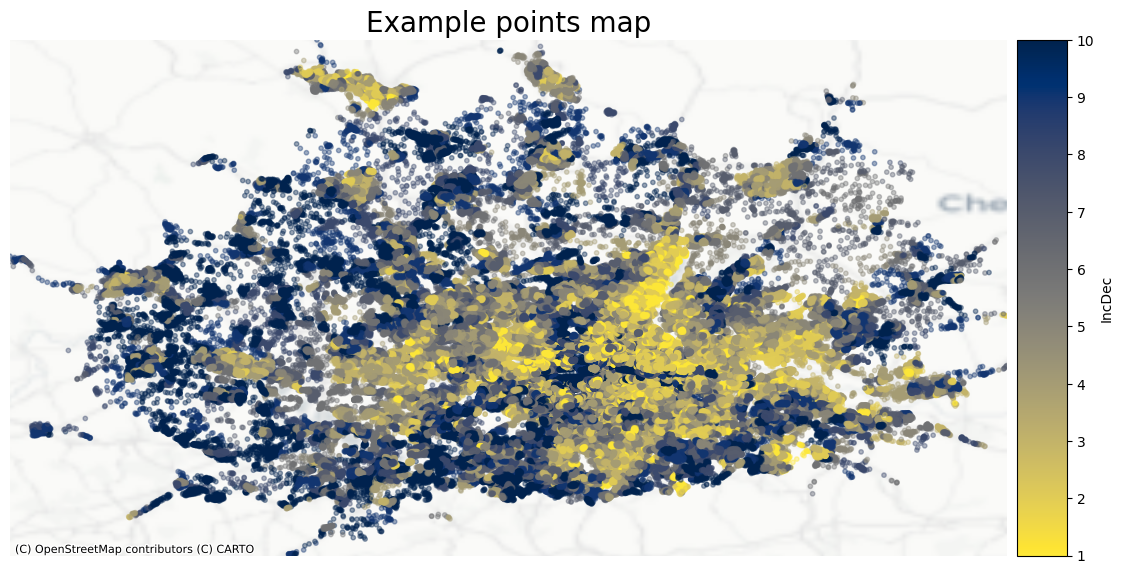

In [346]:
# plot points

var = 'IncDec'


fig = plt.figure(figsize = (30,30))
ax = fig.add_subplot(121)

divider = make_axes_locatable(ax)

minx, miny, maxx, maxy = joined_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

cax = divider.append_axes("right", size="5%", pad=0.1)

joined_gdf.plot(
        ax = ax,
        legend = True,
        cax = cax,
        legend_kwds={'label': var},
        cmap = 'cividis_r',
        marker='o',
        markersize = 10,
        alpha = .4,
        column = var)

ax.axis('off')

# Add title
ax.set_title('Example points map', fontdict={'fontsize': 20}, loc='center')

# add the contextily basemap
ctx.add_basemap(ax, source = ctx.providers.CartoDB.Positron, crs=joined_gdf.crs, zoom=8)

    
# plt.savefig(path + 'Example_points_map.png', dpi=300, bbox_inches='tight')

# Interactive maps using Folium

In [347]:
# see Yodel map code

# Getting Drive Distance (based on route, not as the crow flies or and the worm burrows) and Creating Isochones

In [296]:
start_long = -0.969651
start_lat = 51.456659

end_long = -1.796500
end_lat = 53.800910	


In [327]:
import openrouteservice
from shapely.geometry import shape

# enter your API key for open route service
# my_key = ''

# Create a client instance
client = openrouteservice.Client(key=my_key) 

# Define coordinates for start and end points
coords = ((start_long, start_lat), (end_long, end_lat))

# Calculate driving route
route = client.directions(coordinates=coords, profile='driving-car', format='geojson')

# Extract distance from the route
distance = route['features'][0]['properties']['segments'][0]['distance']

duration = route['features'][0]['properties']['segments'][0]['duration']

print(f"Driving distance: {distance/1000} km \nDriving time: {duration/3600} hours")


Driving distance: 328.6921 km 
Driving time: 3.76275 hours


In [459]:
# You can have a look at the route info below
route

{'type': 'FeatureCollection',
 'metadata': {'attribution': 'openrouteservice.org | OpenStreetMap contributors',
  'service': 'routing',
  'timestamp': 1692298995101,
  'query': {'coordinates': [[-0.969651, 51.456659], [-1.7965, 53.80091]],
   'profile': 'driving-car',
   'format': 'geojson'},
  'engine': {'version': '7.1.0',
   'build_date': '2023-07-09T01:31:50Z',
   'graph_date': '2023-08-13T10:08:47Z'}},
 'bbox': [-1.796394, 51.456589, -0.937551, 53.801036],
 'features': [{'bbox': [-1.796394, 51.456589, -0.937551, 53.801036],
   'type': 'Feature',
   'properties': {'transfers': 0,
    'fare': 0,
    'segments': [{'distance': 328692.1,
      'duration': 13545.9,
      'steps': [{'distance': 144.0,
        'duration': 20.7,
        'type': 11,
        'instruction': 'Head south on Blagrave Street',
        'name': 'Blagrave Street',
        'way_points': [0, 7]},
       {'distance': 239.9,
        'duration': 62.2,
        'type': 1,
        'instruction': 'Turn right onto Station Roa

In [460]:
# Calculate Isochrone

client = openrouteservice.Client(key=my_key)

# Define a location
location = [(start_long, start_lat)]

# Define range (in seconds)
ranges = [600]

# Calculate isochrone
isochrone = client.isochrones(locations=location, 
                              profile='driving-car',
                              range_type='time', 
                              range=ranges, 
                              interval=600)



In [461]:
# Convert to GeoDataFrame
gdf_iso = gpd.GeoDataFrame.from_features(isochrone['features'])
gdf_iso = gdf_iso.set_crs('EPSG:4326')

In [462]:
gdf_iso.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

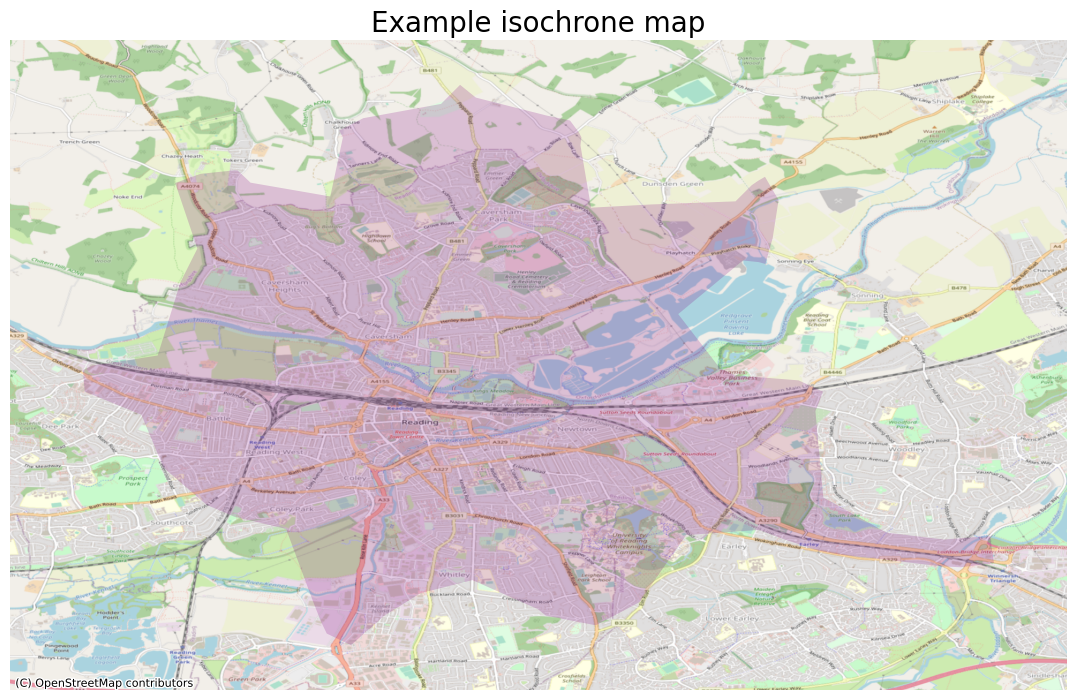

In [464]:
# plot

fig = plt.figure(figsize = (30,30))
ax = fig.add_subplot(121)

divider = make_axes_locatable(ax)

minx, miny, maxx, maxy = gdf_iso.total_bounds
x_buffer = (maxx - minx) * 0.08
y_buffer = (maxy - miny) * 0.08

minx -= x_buffer
miny -= y_buffer
maxx += x_buffer
maxy += y_buffer

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

gdf_iso.plot(ax = ax,
              color = 'purple',
              alpha = .2)


ax.axis('off')
# Add title
ax.set_title('Example isochrone map', fontdict={'fontsize': 20}, loc='center')

# # add the contextily basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf_iso.crs)



plt.savefig(path + 'Example_isochrone.png', dpi=300, bbox_inches='tight')


# Save points or polygons as a shapefile
### These can be uploaded in tableau or used elsewhere. You can also save as geojson or to excel or csv etc by changing the extension.

In [ ]:
gdf.to_file("/path/filename.shp")
